In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from helper import *

from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

# feats = ['actual_weight','declared_horse_weight','draw','win_odds','jockey_ave_rank','trainer_ave_rank',
# 'recent_ave_rank','race_distance']
feats = ['actual_weight','declared_horse_weight','win_odds','jockey_ave_rank','trainer_ave_rank',
'recent_ave_rank','race_distance']
targs = ['HorseWin','HorseRankTop3','HorseRankTop50Percent']

#runs = pd.read_csv("total.csv")
tr = pd.read_csv("training.csv")
te = pd.read_csv("testing.csv")
runs = pd.concat([tr,te]).drop(["level_0"],axis=1)

# Add a race size column

# horse_count = np.zeros(len(runs), dtype=int)
# for r in np.unique(runs["race_id"]):
#     horse_count[runs.loc[runs["race_id"]==r].index] = len(runs.loc[runs["race_id"]==r])
    
# runs["horse_count"] = horse_count
# runs.to_csv("total.csv")

In [2]:
runs.head()

,Unnamed: 0,index,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,...,running_position_5,running_position_6,race_id,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank,recent_ave_rank
0,0,0,1,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133,1032,...,NaN,NaN,2014-001,1400,1,1,1,0.0,0.0,0.0
1,1,1,2,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133,1075,...,NaN,NaN,2014-001,1400,0,1,1,0.0,0.0,0.0
2,2,2,3,10.0,GOLDWEAVER,P072,Y T Cheng,Y S Tsui,121,1065,...,NaN,NaN,2014-001,1400,0,1,1,0.0,0.0,0.0
3,3,3,4,3.0,SUPREME PROFIT,P230,J Moreira,C S Shum,132,1222,...,NaN,NaN,2014-001,1400,0,0,1,0.0,0.0,0.0
4,4,4,5,7.0,THE ONLY KID,H173,Z Purton,K W Lui,125,1136,...,NaN,NaN,2014-001,1400,0,0,1,0.0,0.0,0.0


In [55]:
def makeBets_1(model, X_train, y_train, testing_in, X_test, y_test, target, betSize=1, startMoney=100):
    # Fit and predict
    testing = testing_in.copy()
    betSize = float(betSize)
    model.fit(X_train, y_train[target])
    a = model.predict(X_test)
    testing["predictions"] = a
    
    money = [startMoney]
    winCount=0
    oddsSum = []
    count = 0
    for i, r in enumerate(np.unique(testing["race_id"])):
        act = testing.loc[testing["race_id"]==r][target]
        odds = testing.loc[testing["race_id"]==r]["win_odds"]
        preds = testing.loc[testing["race_id"]==r]["predictions"]
        
        oddsSum.append(sum(odds))
        
        #if i < 10:
            #print("Act", act.values)
            #print("Preds", preds.values)
            #print("Odds", odds.values)
        
        newMoney = money[-1]
        
        if newMoney < 1: # if we run out of money
            #money = money + list(np.zeros(len(test_race_sizes[i:])))
            return money

        if sum(preds)==1: # One win, bet on it
            win_horse_i = np.argmax(preds)
            if act.iloc[win_horse_i]==betSize:
                winCount += 1
                newMoney = money[-1] - betSize + betSize*odds.iloc[win_horse_i]
            else:
                newMoney = money[-1] - betSize
                
#         elif sum(preds)>1: # more than one win, find lowest odds one and bet on it
#             win_horse_i = np.argmin(odds.iloc[np.where(preds==1)])
#             if act.iloc[win_horse_i]==1:
#                 winCount+=1
#                 newMoney = money[-1] - betSize + betSize*odds.iloc[win_horse_i]
#             else:
#                 newMoney = money[-1] - betSize
            
        money.append(newMoney) 
    print(winCount/float(len(money)))
    return money

def bestOddsEval(testing_in, betSize=1, startMoney=100):
    # Fit and predict
    testing = testing_in.copy()
    betSize = float(betSize)
    
    money = [startMoney]
    
    count = 0
    for i, r in enumerate(np.unique(testing["race_id"])):
        act = testing.loc[testing["race_id"]==r][target]
        odds = testing.loc[testing["race_id"]==r]["win_odds"]
        winHorse = np.argmin(odds)
        
        if act.iloc[winHorse]==1:
            newMoney = money[-1] - betSize + betSize*odds.iloc[winHorse]
        else:
            newMoney = money[-1] - betSize
        
        money.append(newMoney) 
        
    return money

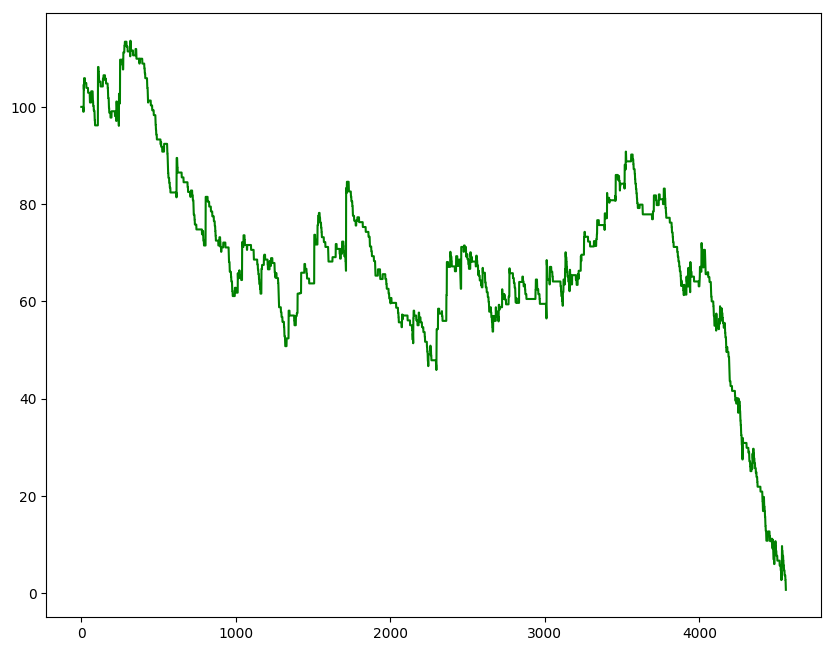

In [57]:
X_train = runs[feats]
y_train = runs
X_test = runs_2[feats]
y_test = runs_2

n = makeBets_1(model, X_train, y_train, runs_2, X_test, y_test, target, betSize=1, startMoney=100)
plt.figure(figsize=(10,8), dpi=100)
plt.plot(n, "g")

0.04720692368214005
0.05428796223446106
0.06058221872541306
0.08110236220472442
0.06377952755905512
0.22736842105263158
0.22105263157894736
0.19831223628691982
0.1940928270042194
0.21308016877637131


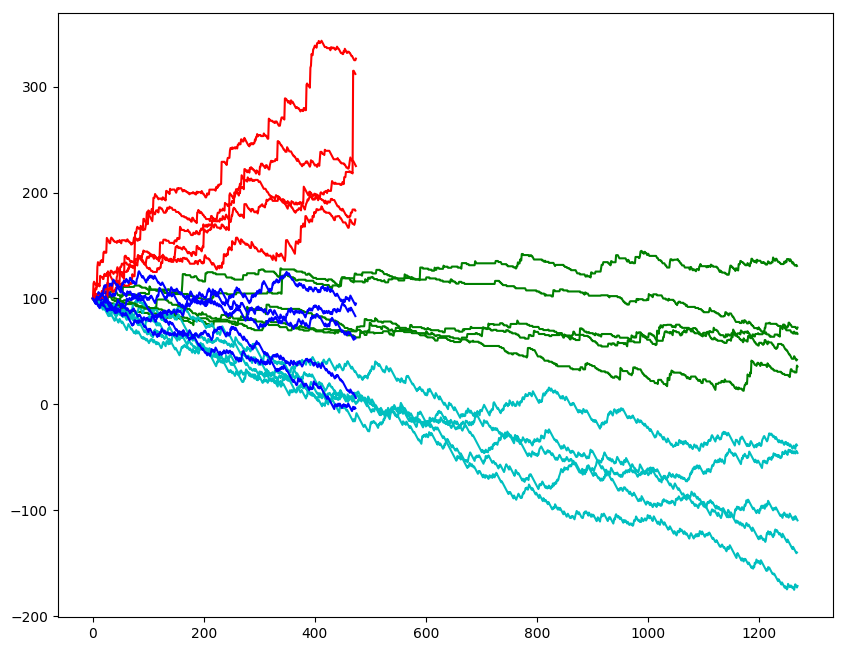

In [30]:
from sklearn.model_selection import cross_val_score
runs_2 = pd.read_csv("total_3.csv")

kfold = KFold(n_splits = 5)
plt.figure(figsize=(10,8), dpi=100)
for training, testing in getCrossVal(runs_2, 5):
    model = GaussianNB()
    X_train = training[feats]
    y_train = training
    X_test = testing[feats]
    y_test = testing
    target = "HorseWin"
    #print(np.mean(cross_val_score(model,X_train,y_train['HorseWin'],cv=kfold,scoring='f1')))
    b = bestOddsEval(testing)
    n = makeBets_1(model, X_train, y_train, testing, X_test, y_test, target, betSize=1, startMoney=100)
    #n = makeBets_2(model, X_train, y_train, testing, X_test, y_test, target)
    plt.plot(n, "g")
    plt.plot(b,'c')

for training, testing in getCrossVal(runs, 5):
    model = GaussianNB()
    X_train = training[feats]
    y_train = training[targs]
    X_test = testing[feats]
    y_test = testing[targs]
    #print(np.mean(cross_val_score(model,X_train,y_train['HorseWin'],cv=kfold,scoring='f1')))
    target = "HorseWin"
    b = bestOddsEval(testing)
    n = makeBets_1(model, X_train, y_train, testing, X_test, y_test, target, betSize=1, startMoney=100)
    plt.plot(n, "r")
    plt.plot(b,'b')

ValueError: Length of values does not match length of index

In [38]:
y_test

,Unnamed: 0,race_id,horse_no,HorseID,Pla,HorseWin,lengths_behind,horse_age,horse_country,horse_type,...,lowest_actual_weight,new_horse,start_speed,surface,surface_record,rode_before,placed,jockey_ave_rank,trainer_ave_rank,recent_ave_rank
0,0,0,1,3917,10,0,8.00,3,AUS,Gelding,...,0,1,21.135438,0,1.000000,0,0,0.000000,0.000000,0.000000
1,1,0,2,2157,8,0,5.75,3,NZ,Gelding,...,0,1,21.135438,0,1.000000,0,0,0.000000,0.000000,0.000000
2,2,0,3,858,7,0,4.75,3,NZ,Gelding,...,0,1,21.135438,0,1.000000,0,0,0.000000,0.000000,0.000000
3,3,0,4,1853,9,0,6.25,3,SAF,Gelding,...,0,1,21.135438,0,1.000000,0,0,0.000000,0.000000,0.000000
4,4,0,5,2796,6,0,3.75,3,GB,Gelding,...,0,1,21.135438,0,1.000000,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79442,79442,6348,10,1238,6,0,1.25,5,AUS,Gelding,...,0,0,23.378800,0,0.352903,1,0,7.165577,6.824379,7.500000
79443,79443,6348,11,985,7,0,2.25,5,NZ,Gelding,...,0,0,25.208571,0,0.441144,1,0,7.254579,6.807519,6.833333
79444,79444,6348,12,3147,10,0,3.00,5,NZ,Gelding,...,0,0,19.840000,0,0.350945,0,0,7.988701,6.988621,7.833333
79445,79445,6348,13,1982,8,0,2.50,3,AUS,Gelding,...,0,0,24.600000,0,0.071429,1,0,4.291139,5.604069,4.500000
